In [2]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
import math


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import *
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, r2_score

source_word2idx = {}
target_word2idx = {}
source_data = []
source_loc_data = []
target_data = []
target_label = []

final_list = []
max_length = 0

def read_data(file):
    data_train_1 = pd.read_csv(file)
    return data_train_1

def read_and_process_data(data_train_1, sourceWord2idx, targetWord2idx):
    global source_word2idx
    global target_word2idx
    source_word2idx = sourceWord2idx
    target_word2idx = targetWord2idx
    #parse_data(data_train_1)
    #create_vocab(data_train_1)
    data_train_1.apply(prepare_data,axis = 1)
    return source_data, source_loc_data, target_data, target_label, max_length


def split_data(data_train_1, train_size, test_size):
    size = data_train_1.shape[0]
    training_rows = math.ceil((train_size/100)*size)
    testing_rows = size - training_rows
    train_data = data_train_1.iloc[0:training_rows]
    test_data = data_train_1.iloc[training_rows:]
    return train_data, test_data


def custom_tokenize(text):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(text)
    words = [word for word in tokens if word.isalnum()]
    return words


def parse_data(data_train_1):
    data_train_1[' text'] = data_train_1[' text'].apply(lambda x: x.replace('[comma]',',').lower())
    data_train_1[' text'] = data_train_1[' text'].apply(custom_tokenize)
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(lambda x: x.lower())
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(custom_tokenize)
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(lambda x:" ".join(x))
    return data_train_1


def prepare_data(row):
    global max_length
    global source_word2idx
    global target_word2idx
    m = [source_word2idx[id] for id in row[' text']]
    if len(m) == 2602:
        print(row[' text'])
    if len(m) > max_length:
        max_length = len(m)
    source_data.append(m)
    t = [target_word2idx[row[' aspect_term']]]
    target_data.append(t)
    target_label.append(row[' class'])
    g = get_pos(row)
    datab = []
    datab.append(m)
    datab.append(g)
    datab.append(t)
    final_list.append(datab)


def get_pos_old(row):
    index = []
    s_len = len(row[' text'])-1
    p = row[' text'].copy()
    #print('%s in %s: '%(row[' aspect_term'],row[' text']))
    aspects = row[' aspect_term'].split(' ')
    for aspect in aspects:
        try:
            if len(aspects)-1 > aspects.index(aspect):
                a_i = [i for i,val in enumerate(row[' text']) if val==aspect]
                #print(a_i)
                
                for a_id in a_i:
                    try:
                        if row[' text'][a_id+1] != aspects[aspects.index(aspect)+1]:
                            a_i.remove(a_id)
                    except:
#                         print('a_i',a_i)
#                         print('a_id',a_id)
#                         print(a_i.index(a_id))
                        a_i = a_i[:a_i.index(a_id)+1]
#                         print('exception', a_i)
                        break;
    #             index.append(row[' text'].index(aspect))
                index.extend(a_i)
                #print(index)
                for i in index:
                    p[i] = s_len
            else:
                index.append(row[' text'].index(aspect))
                p[row[' text'].index(aspect)] = s_len
        except:
            pass
    try:
        for i in range(index[0]):
#             p[i] = index[0] - i
            p[i] = s_len - index[0] + i
        v = s_len
        for i in range(index[len(index)-1],len(p)):
            #p[i] = i - index[len(index)-1]
            if i == index[len(index)-1]:
                p[i] = v
            else:    
                p[i] = v - 1
                v = v-1
            
        #print(p)
    except Exception as e: 
#         print(e)
#         print(p)
#         print('exception caught')
#         print('%s,%s'%(row[' text'],row[' aspect_term']))
        p = [0 for i in row[' text']]
#         print(p)
    #print(source_loc_data)
    source_loc_data.append(p)
    return p


def get_pos(row):
    index = []
    s_len = len(row[' text'])-1
    p = row[' text'].copy()
    #print('%s in %s: '%(row[' aspect_term'],row[' text']))
    aspects = row[' aspect_term'].split(' ')
    for aspect in aspects:
        try:
            if len(aspects)-1 > aspects.index(aspect):
                a_i = [i for i,val in enumerate(row[' text']) if val==aspect]
                try:
                    for a_id in a_i:
                        if row[' text'][a_id+1] != aspects[aspects.index(aspect)+1]:
                            a_i.remove(a_id)
                except:
                    pass
    #             index.append(row[' text'].index(aspect))
                index.extend(a_i[0])
            else:
                index.append(row[' text'].index(aspect))
            p[row[' text'].index(aspect)] = s_len
        except:
            pass
    try:
        for i in range(index[0]):
#             p[i] = index[0] - i
            p[i] = s_len - index[0] + i
        v = s_len
        for i in range(index[len(index)-1],len(p)):
            #p[i] = i - index[len(index)-1]
            if i == index[len(index)-1]:
                p[i] = v
            else:    
                p[i] = v - 1
                v = v-1
            
        #print(p)
    except Exception as e: 
#         print(e)
#         print(p)
#         print('exception caught')
#         print('%s,%s'%(row[' text'],row[' aspect_term']))
        p = [0 for i in row[' text']]
#         print(p)
    source_loc_data.append(p)
    return p


def create_vocab(data_train_1):
    source_word2idx = {'<pad>': 0}
    target_word2idx = {}
    for words in data_train_1[' text']:
        for word in words:
            if word not in source_word2idx:
                source_word2idx[word] = len(source_word2idx)

    for words in data_train_1[' aspect_term']:
        if words not in target_word2idx:
            target_word2idx[words] = len(target_word2idx)
    return source_word2idx, target_word2idx

In [3]:
train_file = 'data/data_2_train.csv'
#train_file = 'data/data_2_train.csv'

data = read_data(train_file)
parsed_data = parse_data(data)
source_word2idx, target_word2idx = create_vocab(parsed_data)

#trainData, testData = process_data.split_data(parsed_data, 80, 20)
train_data = read_and_process_data(parsed_data, source_word2idx, target_word2idx)
#test_data = process_data.read_and_process_data(testData, source_word2idx, target_word2idx)

In [4]:

x1_list, x2_list, x3_list = list(), list(), list()
example_list = list()

sen_max_len = train_data[4]
print("sen_max_len: ",sen_max_len)

for i in range(len(train_data[0])):
    x1, x2, x3 = list(), list(), list()
    
    x1.extend(train_data[0][i])
    if len(x1) < sen_max_len:
        for _ in range(sen_max_len - len(x1)):
            x1.append(0)
    
    x2.extend(train_data[1][i])
    if len(x2) < sen_max_len:
        for _ in range(sen_max_len - len(x2)):
            x2.append(0)
            
    x3.extend(train_data[2][i])
    for j in range(len(x1) - 1):
        x3.append(x3[0])
    for k in range(sen_max_len - len(x3)):
        x3.append(0)
    
    example = list()
    example.append(x1)
    example.append(x2)
    example.append(x3)
    #print("example: ",example)
    example_list.append(example)

len(example_list)

final_array = np.array(example_list)
print(final_array.shape)

nsamples, nx, ny = final_array.shape
feature_vector = final_array.reshape((nsamples,nx*ny))
print(feature_vector.shape)
labels = train_data[3]

sen_max_len:  70
(3602, 3, 70)
(3602, 210)


In [5]:
len(labels)

3602

In [6]:
from collections import Counter
Counter(labels).keys() # equals to list(set(words))
# counts the elements' frequency
Counter(labels).values() 

dict_values([805, 2164, 633])

In [7]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_sample(feature_vector, labels)
print(sorted(Counter(y_resampled).items()))

[(-1, 2164), (0, 2164), (1, 2164)]


In [8]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

In [9]:
train_vectors.shape

(5193, 210)

In [10]:
from collections import Counter
Counter(train_labels).keys() # equals to list(set(words))
# counts the elements' frequency
Counter(train_labels).values() 

dict_values([1731, 1730, 1732])

In [14]:
print(train_vectors.shape)
print(train_labels.shape)
print(test_vectors.shape)
print(test_labels.shape)
print(type(train_labels))

(5193, 210)
(5193,)
(1299, 210)
(1299,)
<class 'numpy.ndarray'>


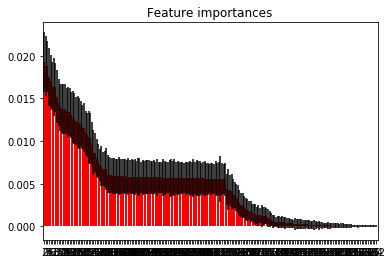

In [15]:
%matplotlib inline
from matplotlib import pylab as plt

from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
X = train_vectors
y = train_labels
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
importances.shape
train_vectors.shape[0]
train_X = np.zeros(shape=(train_vectors.shape[0],50))
train_X.shape

(5193, 50)

In [17]:

for i in range(train_vectors.shape[0]):
    for j in range(50):
        # print("indices [",j,"]: ",indices[j], " train_vectors[i][indices[j]]:",train_vectors[i][indices[j]])
        train_X[i][j] = train_vectors[i][indices[j]]
        
print("***************************")  
print(train_X[i][j])

***************************
111.0


In [18]:
from sklearn.ensemble import RandomForestClassifier as RFR
#10,20,50,80
n_estimators = [100,200,500]
rfr = RFR(n_estimators=100,random_state=0)

print("Results for RFR: ")
print()

rfr_scores = cross_val_score(rfr, train_vectors, train_labels, cv=10)  
print('scores: ', rfr_scores)

rfr.fit(train_vectors,train_labels)
y_pred = rfr.predict(test_vectors) 

rfr_accuracy = accuracy_score(test_labels, y_pred)

print()

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",rfr_accuracy)

Results for RFR: 

scores:  [0.75047985 0.73076923 0.78805395 0.78612717 0.76685934 0.80539499
 0.74373796 0.73410405 0.7495183  0.74759152]


             precision    recall  f1-score   support

         -1       0.78      0.78      0.78       433
          0       0.79      0.78      0.79       432
          1       0.75      0.76      0.76       434

avg / total       0.77      0.77      0.77      1299

Overall accuracy:  0.7744418783679754


In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
print("Results for DecisionTreeClassifier: ")
print()
rfr_scores = cross_val_score(rfr, train_vectors, train_labels, cv=10)  
print('scores: ', rfr_scores)

dt_clf.fit(train_vectors,train_labels)
y_pred = dt_clf.predict(test_vectors)

accuracy = accuracy_score(test_labels, y_pred)

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",accuracy)

Results for DecisionTreeClassifier: 

scores:  [0.75047985 0.73076923 0.78805395 0.78612717 0.76685934 0.80539499
 0.74373796 0.73410405 0.7495183  0.74759152]

             precision    recall  f1-score   support

         -1       0.63      0.63      0.63       433
          0       0.65      0.68      0.67       432
          1       0.66      0.65      0.66       434

avg / total       0.65      0.65      0.65      1299

Overall accuracy:  0.651270207852194


In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

scores = cross_val_score(knn, train_vectors, train_labels, cv=10)  
print('scores: ', scores)

knn.fit(train_vectors, train_labels)
y_pred = knn.predict(test_vectors)

accuracy = accuracy_score(test_labels, y_pred)

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",accuracy)

scores:  [0.66410749 0.65576923 0.69171484 0.68400771 0.68786127 0.68208092
 0.64547206 0.66859345 0.68978805 0.67244701]

             precision    recall  f1-score   support

         -1       0.68      0.84      0.75       433
          0       0.68      0.89      0.77       432
          1       0.81      0.39      0.53       434

avg / total       0.73      0.70      0.68      1299

Overall accuracy:  0.7036181678214011


In [21]:
svc_classifier = svm.SVC(C = 100)

classifier_svc_scores = cross_val_score(svc_classifier, train_vectors, train_labels, cv=10)  
print('scores: ', classifier_svc_scores)

svc_classifier.fit(train_vectors, train_labels)
prediction_svc = svc_classifier.predict(test_vectors)

classifier_svc_accuracy = accuracy_score(test_labels, prediction_svc)
print('classifier_svc_accuracy: ', classifier_svc_accuracy)

print("")
print(classification_report(test_labels, prediction_svc))
print("Overall accuracy: ",classifier_svc_accuracy)

scores:  [0.3915547  0.40961538 0.39691715 0.39306358 0.41811175 0.39884393
 0.39691715 0.39884393 0.41040462 0.39884393]
classifier_svc_accuracy:  0.4095458044649731

             precision    recall  f1-score   support

         -1       0.90      0.10      0.19       433
          0       0.92      0.13      0.23       432
          1       0.36      0.99      0.53       434

avg / total       0.73      0.41      0.32      1299

Overall accuracy:  0.4095458044649731


In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf1 = VotingClassifier(estimators=[('rfr', rfr), ('knn', knn), ('dt_clf', dt_clf)], voting='hard')
eclf1 = eclf1.fit(train_vectors, train_labels)
eclf1_pred = eclf1.predict(test_vectors)
eclf1_accuracy_score = accuracy_score(test_labels, eclf1_pred)
print(eclf1_accuracy_score)

eclf2 = VotingClassifier(estimators=[('rfr', rfr), ('knn', knn), ('dt_clf', dt_clf)], voting='soft')
eclf2 = eclf2.fit(train_vectors, train_labels)
eclf2_pred = eclf2.predict(test_vectors)
eclf2_accuracy_score = accuracy_score(test_labels, eclf2_pred)
print(eclf2_accuracy_score)



C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7859892224788299
0.7359507313317937


C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
